In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
print("Initialized TensorFlow")
set_session(sess)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


Initialized TensorFlow


### Keras MNIST CNN
Defining function f() and gradient

For mnist and Keras, see http://keras.io/examples/mnist_cnn/

In [3]:
def get_mnist():
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train, y_test, input_shape

In [4]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

x_train, x_test, y_train, y_test, input_shape = get_mnist()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
# output (correct)
output_tensor = tf.placeholder(tf.float32, (None, 10))

In [6]:
# defining the loss function (non-convex...)
loss = tf.reduce_mean(keras.losses.categorical_crossentropy(output_tensor, model.output))

In [7]:
# model parameters (x)
weights = model.weights

In [8]:
# loss gradient
grads = tf.gradients(loss, weights)

In [9]:
# classification accuracy
accuracy = tf.reduce_mean(keras.metrics.categorical_accuracy(output_tensor, model.output))

In [10]:
# some batch data
x_batch = x_train[:1000]
y_batch = y_train[:1000]

### Frank-Wolfe (conditional gradient method)

**Problem:**
$$
\min\limits_{x\in X}f(x)
$$

**Method:** Choosing a direction $s_{t}\in\arg\min\limits_{x\in X}\nabla f(x_t)^T x$ (linear oracle) and taking a step $x_{t+1}=(1-\gamma_t)x_t+\gamma_ts_t$ for $\gamma_t=2/(t+1)$

**Motivation:** solving linear oracle might be simpler than doing a projection step.

In this notebook I a neural net and apply vanilla Frank-Wolfe for it.

Define the set $X = \{x\in\mathbb{R}^n\big| \|x\|_p\leq R\}$ and $f(x)=L(x)$ for loss of a neural net $L(x)$

Then for any $x$, $\nabla f(x)$ is **calculated using TensorFlow.**

**Linear oracle:** Now we need to compute $\min\limits_{\|s\|_p\leq R}g^T s$ which gives $s(g)=-R|g|^{q/p}\mbox{sign} g/\|g\|_q^{q/p}$ for $q$ s.t. $1/p+1/q=1$

In [11]:
# set radius of the ball
R = 0.5

# norm order
p = 3.1
q = 1. / (1 - 1. / p)

In [12]:
def get_p_vector_norm(list_of_tensors, order):
    """ p-norm of a list of tensors flattened to a vector """
    # weights as a vector
    weights_flattened = tf.concat([tf.reshape(w, (-1,)) for w in list_of_tensors], axis = 0)
    
    # p-norm of the weights (must be <= R)
    weight_p_norm = tf.norm(weights_flattened, ord = order)
    
    return weight_p_norm

In [13]:
# p-norm of weights
weight_p_norm = get_p_vector_norm(weights, p)

# gradients p-norm
grad_p_norm = get_p_vector_norm(grads, p)

# slack of constraint
constraint_slack = R - weight_p_norm

In [14]:
def LMO(g):
    """ Linear oracle for a list of tensors """
    
    # overall norm
    g_q_qp_norm = get_p_vector_norm(g, q) ** (q / p)
    
    g_qp = [tf.abs(g0) ** (q / p) for g0 in g]
    g_qp_signed = [tf.multiply(g_qp0, tf.sign(g0)) for g_qp0, g0 in zip(g_qp, g)]

    return [-R * g_qp_signed0 / g_q_qp_norm for g_qp_signed0 in g_qp_signed]

# descent from LMO
descent_direction = LMO(grads)

In [15]:
# FW gamma parameter
gamma = tf.placeholder(tf.float32)

In [16]:
# implementing FW update x = (1 - gamma_t) * x + gamma_t * s_t
frank_wolfe_op = tf.group([w.assign((1. - gamma) * w + gamma * s)
                           for w, s in zip(weights, descent_direction)])

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
# loss values
losses = []

# constraint slacks
slacks = []

# gradient norms
gradnorms = []

# accuracies
accs = []

# initial gamma
gamma_initial = 0.5

# iterations
for t in range(100):
    # current step
    gamma_t = 2. * gamma_initial / (t + 2)
    
    # making the step
    _, slack, w_n, g_n, l, a = sess.run([frank_wolfe_op, constraint_slack, weight_p_norm,
                                      grad_p_norm, loss, accuracy],
             feed_dict = {model.input: x_batch, output_tensor: y_batch, gamma: gamma_t})
    # calculating loss
    losses += [l]
    slacks += [slack]
    gradnorms += [g_n]
    accs += [a]

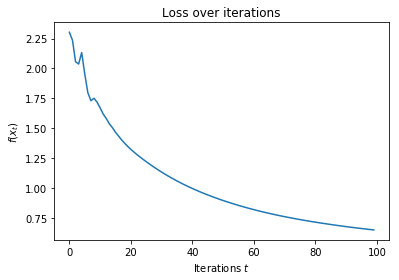

In [19]:
plt.title('Loss over iterations')
plt.xlabel('Iterations $t$')
plt.ylabel('$f(x_t)$')
plt.plot(losses)
plt.show()

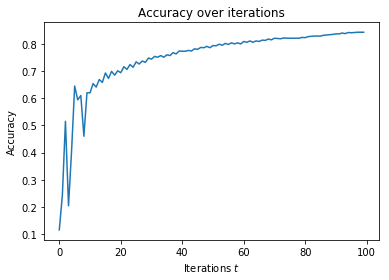

In [20]:
plt.title('Accuracy over iterations')
plt.xlabel('Iterations $t$')
plt.ylabel('Accuracy')
plt.plot(accs)
plt.show()

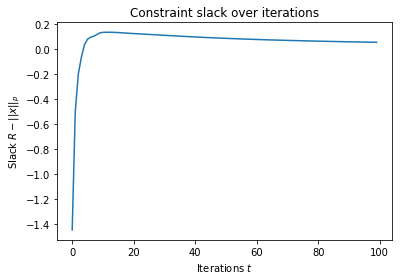

In [21]:
plt.title('Constraint slack over iterations')
plt.xlabel('Iterations $t$')
plt.ylabel('Slack $R-||x||_p$')
plt.plot(slacks)
plt.show()

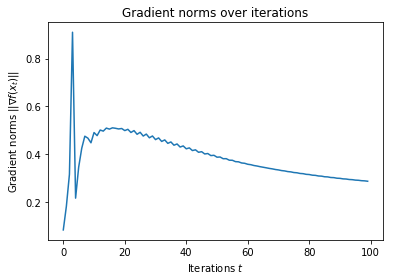

In [22]:
plt.title('Gradient norms over iterations')
plt.xlabel('Iterations $t$')
plt.ylabel('Gradient norms $||\\nabla f(x_t)||$')
plt.plot(gradnorms)
plt.show()